# Preamble

In [2]:
import numpy as np
import matplotlib.pylab as plt

import pymc as pm
import arviz as az
import aesara.tensor as at
import aesara.tensor.extra_ops as ate

import astropy.cosmology as cosmo
import astropy.units as u
import h5py

# Data Generation

Redshift Distribution approximately follows M-D 2014.
$$
z \sim 10\beta_z(3, 9)
$$

In [3]:
Nobs = 1000

Text(0, 0.5, 'Number')

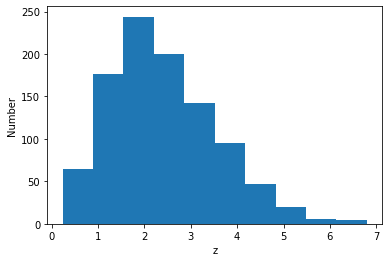

In [4]:
z = np.random.beta(3, 9, Nobs)*10
plt.hist(z)
plt.xlabel('z')
plt.ylabel('Number')

Source frame chirp mass follows galactic neutron star population (https://arxiv.org/pdf/2106.15745.pdf):

Recycled Component,
$$
p_r(m_r|\vec{\lambda}_r) = w.N_{m_r}(\mu_1, \sigma_1)+(1-w).N_{m_r}(\mu_2, \sigma_2)
$$

Slow Component,
$$
p_s(m_s|\vec{\lambda}_s) = U_{m_s}(l, u)
$$

Each component is given by,
$$
m_1 = max(m_r, m_s), ~m_2 = min(m_r, m_s)
$$

Text(0, 0.5, 'Number')

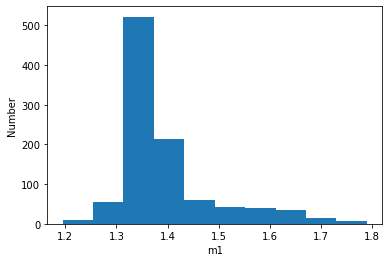

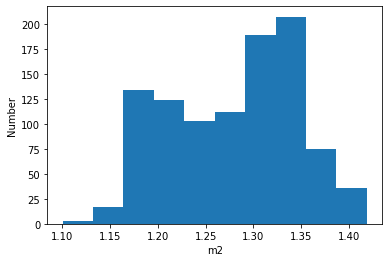

In [5]:
def sample(p, Nsam=Nobs):
    mu1,s1,mu2,s2,w,l,u = p[0],p[1],p[2],p[3],p[4],p[5],p[6]
    Ones = np.random.uniform(0.,1.,Nsam)
    S1 = np.zeros(Nsam)
    arg1 = np.where(Ones<=w)[0]
    arg2 = np.where(Ones>w)[0]
    S1[arg1] = np.random.normal(mu1,s1,len(arg1))
    S1[arg2] = np.random.normal(mu2,s2,len(arg2))
    S2 = np.random.uniform(l,u,Nsam)
    m1 = np.array([max(s1,s2) for s1,s2 in zip(S1,S2)])
    m2 = np.array([min(s1,s2) for s1,s2 in zip(S1,S2)])
    if Nsam==1:
        return m1[0],m2[0]
    else:
        return m1,m2
    
p = np.array([1.34, 0.02, 1.47, 0.15, 0.68, 1.16, 1.42])

m1, m2 = sample(p)

plt.hist(m1)
plt.xlabel('m1')
plt.ylabel('Number')

plt.figure()
plt.hist(m2)
plt.xlabel('m2')
plt.ylabel('Number')

Text(0, 0.5, 'Number')

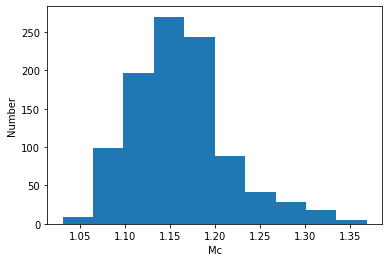

In [6]:
Mc = (m1*m2)**0.6/((m1+m2)**0.2)
plt.hist(Mc)
plt.xlabel('Mc')
plt.ylabel('Number')

Text(0, 0.5, 'Number')

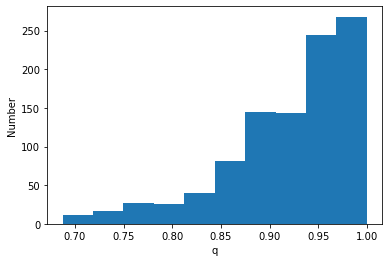

In [7]:
q = m2/m1
plt.hist(q)
plt.xlabel('q')
plt.ylabel('Number')

Detector frame chirp mass,
$$
Mcz = Mc(1+z)
$$

Text(0, 0.5, 'Number')

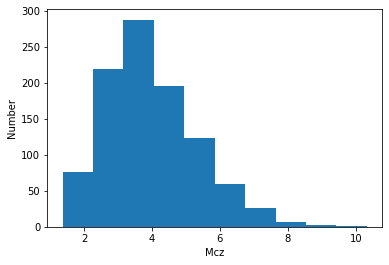

In [8]:
Mcz = Mc*(1+z)
plt.hist(Mcz)
plt.xlabel('Mcz')
plt.ylabel('Number')

We assume
$$
\sigma_{logq} = 0.1 
$$
more or less consistent with GW170817.

In [9]:
sigma_logq = np.full(Nobs, 0.1)

logqo = np.log(q)+sigma_logq*np.random.randn(Nobs)

Cosmology is assumed to be Planck18. $\sigma_{DL}/DL$ is inversely proportional to snr, reaching 30% of snr at z=10. Also place a lower cut $\sigma_{DL}/DL$ is 0.1 to avoid unphysical scenario of $\sigma_{DL} \rightarrow 0$ at low $z$.

$$
\frac{\sigma_{DL}}{DL} = 0.1 + 0.3 \frac{DL}{DL(z=10)}
$$

Text(0, 0.5, 'Number')

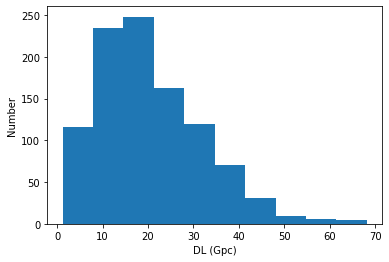

In [10]:
cp = cosmo.Planck18
DL = cp.luminosity_distance(z).to(u.Gpc).value
plt.hist(DL)
plt.xlabel('DL (Gpc)')
plt.ylabel('Number')

In [11]:
DL10 = cp.luminosity_distance(10).to(u.Gpc).value
sigma_logDL = 0.1+0.3*(DL/DL10)

$$
zo = z, do = DL+\sigma_{DL}*randn(Nobs)
$$

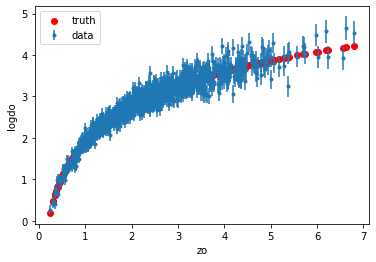

In [12]:
zo = z
logdo = np.log(DL)+sigma_logDL*np.random.randn(Nobs) # in Gpc
plt.errorbar(zo, logdo, yerr=sigma_logDL, fmt='.', label='data')
plt.scatter(zo, np.log(cp.luminosity_distance(zo).to(u.Gpc).value), color='red', label='truth')
plt.xlabel('zo')
plt.ylabel('logdo')
plt.legend()

# Sample Generation

In [13]:
Ns = 10**2

logqs = np.zeros([Nobs, Ns])
for i in range(Nobs):
    logqs[i] = np.random.normal(logqo[i], sigma_logq[i], Ns).T
    
logds = np.zeros([Nobs, Ns])
for i in range(Nobs):
    logds[i] = np.random.normal(logdo[i], sigma_logDL[i], Ns).T

# Pop Cosmo Estimation

Let's plot the residue.

Text(0, 0.5, 'residue')

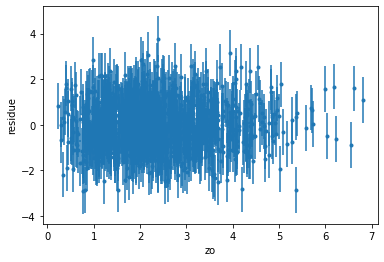

In [14]:
plt.errorbar(zo, (logdo-np.log(cp.luminosity_distance(zo).to(u.Gpc).value))/sigma_logDL, yerr=np.ones(Nobs), fmt='.')
plt.xlabel('zo')
plt.ylabel('residue')

# Toy Model I

Here $\vec{\Omega}_P = \{\mu_P, \sigma_P \}$, and $\vec{\Omega}_C = \{H_0, \Omega_M, w \}$.

Under simplified asuumptions:
1. $cov(M_{cz}^{obs}, logD_L^{obs})=0$ and $cov(logq^{obs}, logD_L^{obs})=0$
2. $\sigma_{M_{cz}^{obs}} = 0$

$M_{cz}$ integral becomes analytic.

Posterior of $\{\mu_P, \sigma_P, H_0, \Omega_M, w \}$ is,

$$
P(\mu_P, \sigma_P, H_0, \Omega_M, w| \bigcap_i D_i) \propto P(\mu_P).P(\sigma_P).P(H_0).P(\Omega_M).P(w).\prod_i \int_{logq, ~logD_L} N_{logq}(logq^{obs, i}, \sigma_{logq}^{obs, i}).N_{logD_L}(logD_L^{obs, i}, \sigma_{logD_L}^{obs, i}).P(logD_L).\Big(\frac{1}{1+z(logD_L, H_0, \Omega_M, w)}\Big ).\Big|J \Big(\frac{M_{cz}^{obs, i}}{1+z(logD_L, H_0, \Omega_M, w)}, q \Big)\Big|.\Big (N_{m_1 \Big( \frac{M_{cz}^{obs, i}}{1+z(logD_L, H_0, \Omega_M, w)}, ~q\Big )}(\mu_P, \sigma_P)\Big ).\Big (N_{m_2 \Big( \frac{M_{cz}^{obs, i}}{1+z(logD_L, H_0, \Omega_M, w)}, ~q\Big )}(\mu_P, \sigma_P)\Big ).dlogq.dlogD_L
$$

Now,

$$
q = \frac{m_2}{m_1}, ~M_c = \frac{(m_1m_2)^{\frac{3}{5}}}{(m_1+m_2)^{\frac{1}{5}}}
$$

This gives,

$$
m_1 = q^{-\frac{3}{5}}(1+q)^{\frac{1}{5}}M_c = q^{-\frac{3}{5}}(1+q)^{\frac{1}{5}}\frac{M_{cz}^{obs, i}}{1+z(logD_L, H_0, \Omega_M, w)}
$$

and,

$$
m_2 = q^{\frac{2}{5}}(1+q)^{\frac{1}{5}}M_c = q^{\frac{2}{5}}(1+q)^{\frac{1}{5}}\frac{M_{cz}^{obs, i}}{1+z(logD_L, H_0, \Omega_M, w)}
$$

Hence,

$$
\Big|J \Big(\frac{M_{cz}^{obs, i}}{1+z(logD_L, H_0, \Omega_M, w)}, q \Big)\Big| = q^{-\frac{6}{5}}(1+q)^{\frac{2}{5}}\frac{M_{cz}^{obs, i}}{1+z(logD_L, H_0, \Omega_M, w)}
$$

So the Posterior of $\{\mu_P, \sigma_P, H_0, \Omega_M, w \}$ becomes,

$$
P(\mu_P, \sigma_P, H_0, \Omega_M, w| \bigcap_i D_i) \propto P(\mu_P).P(\sigma_P).P(H_0).P(\Omega_M).P(w).\prod_i \int_{logq, ~logD_L} N_{logq}(logq^{obs, i}, \sigma_{logq}^{obs, i}).N_{logD_L}(logD_L^{obs, i}, \sigma_{logD_L}^{obs, i}).P(logD_L).\Big(\frac{1}{1+z(logD_L, H_0, \Omega_M, w)}\Big ).\Big( q^{-\frac{6}{5}}(1+q)^{\frac{2}{5}}\frac{M_{cz}^{obs, i}}{1+z(logD_L, H_0, \Omega_M, w)} \Big ).\Big (N_{\Big( q^{-\frac{3}{5}}(1+q)^{\frac{1}{5}}\frac{M_{cz}^{obs, i}}{1+z(logD_L, H_0, \Omega_M, w)} \Big )}(\mu_P, \sigma_P)\Big ).\Big (N_{ \Big( q^{\frac{2}{5}}(1+q)^{\frac{1}{5}}\frac{M_{cz}^{obs, i}}{1+z(logD_L, H_0, \Omega_M, w)} \Big )}(\mu_P, \sigma_P)\Big ).dlogq.dlogD_L
$$

Here we will investigate whether Posterior is more informative than Prior or not.  

Pymc does not have interpolation module, so it is written.

In [15]:
def at_interp(x, xs, ys):
    x = at.as_tensor(x)
    xs = at.as_tensor(xs)
    ys = at.as_tensor(ys)

    ind = ate.searchsorted(xs, x)
    r = (x - xs[ind-1])/(xs[ind]-xs[ind-1])
    return r*ys[ind] + (1-r)*ys[ind-1]

Routine for Luminosity Distance

In [16]:
def Ez(z, Om, w, wDM):
    opz = 1 + z
    return at.sqrt(Om*opz**(3*(1+wDM)) + (1-Om)*opz**(3*(1+w)))

def dCs(zs, Om, w, wDM):
    dz = zs[1:] - zs[:-1]
    fz = 1/Ez(zs, Om, w, wDM)
    I = 0.5*dz*(fz[:-1] + fz[1:])
    return at.concatenate([at.as_tensor([0.0]), at.cumsum(I)])

def dLs(zs, dCs):
    return dCs*(1+zs)

Cosmological Parameter Estimation by Pymc

A note on the maths:
$$
P(\mu_P, \sigma_P, H_0, \Omega_M, w| \bigcap_i D_i) \propto P(\mu_P).P(\sigma_P).P(H_0).P(\Omega_M).P(w).\prod_i \int_{logq, ~logD_L} N_{logq}(logq^{obs, i}, \sigma_{logq}^{obs, i}).N_{logD_L}(logD_L^{obs, i}, \sigma_{logD_L}^{obs, i}).P(logD_L).\Big(\frac{1}{1+z(logD_L, H_0, \Omega_M, w)}\Big ).\Big( q^{-\frac{6}{5}}(1+q)^{\frac{2}{5}}\frac{M_{cz}^{obs, i}}{1+z(logD_L, H_0, \Omega_M, w)} \Big ).\Big (N_{\Big( q^{-\frac{3}{5}}(1+q)^{\frac{1}{5}}\frac{M_{cz}^{obs, i}}{1+z(logD_L, H_0, \Omega_M, w)} \Big )}(\mu_P, \sigma_P)\Big ).\Big (N_{ \Big( q^{\frac{2}{5}}(1+q)^{\frac{1}{5}}\frac{M_{cz}^{obs, i}}{1+z(logD_L, H_0, \Omega_M, w)} \Big )}(\mu_P, \sigma_P)\Big ).dlogq.dlogD_L
$$

or,

$$
P(\mu_P, \sigma_P, H_0, \Omega_M, w| \bigcap_i D_i) \propto \prod_i \left\langle P(logD_L).\Big(\frac{1}{1+z(logD_L, H_0, \Omega_M, w)}\Big ).\Big( q^{-\frac{6}{5}}(1+q)^{\frac{2}{5}}\frac{M_{cz}^{obs, i}}{1+z(logD_L, H_0, \Omega_M, w)} \Big ).\Big (N_{\Big( q^{-\frac{3}{5}}(1+q)^{\frac{1}{5}}\frac{M_{cz}^{obs, i}}{1+z(logD_L, H_0, \Omega_M, w)} \Big )}(\mu_P, \sigma_P)\Big ).\Big (N_{ \Big( q^{\frac{2}{5}}(1+q)^{\frac{1}{5}}\frac{M_{cz}^{obs, i}}{1+z(logD_L, H_0, \Omega_M, w)} \Big )}(\mu_P, \sigma_P)\Big ) \right\rangle _{\mu_P, ~\sigma_P, ~H_0, ~\Omega_M, ~w, ~q \sim exp(N_{logq}(logq^{obs, i}, \sigma_{logq}^{obs, i})), ~D_L \sim exp(N_{logD_L}(logD_L^{obs, i}, \sigma_{logD_L}^{obs, i})) ~samples}
$$

or,

$$
P(\mu_P, \sigma_P, H_0, \Omega_M, w| \bigcap_i D_i) \propto \prod_i \left\langle P(z(D_L, H_0, \Omega_M, w)).
\frac{dz}{dD_L}\Big |_{z(D_L, H_0, \Omega_M, w)}.\frac{dD_L}{dlogD_L}\\
.\Big(\frac{1}{1+z(logD_L, H_0, \Omega_M, w)}\Big ).\Big( q^{-\frac{6}{5}}(1+q)^{\frac{2}{5}}\frac{M_{cz}^{obs, i}}{1+z(logD_L, H_0, \Omega_M, w)} \Big ).\Big (N_{\Big( q^{-\frac{3}{5}}(1+q)^{\frac{1}{5}}\frac{M_{cz}^{obs, i}}{1+z(logD_L, H_0, \Omega_M, w)} \Big )}(\mu_P, \sigma_P)\Big ).\Big (N_{ \Big( q^{\frac{2}{5}}(1+q)^{\frac{1}{5}}\frac{M_{cz}^{obs, i}}{1+z(logD_L, H_0, \Omega_M, w)} \Big )}(\mu_P, \sigma_P)\Big ) \right\rangle _{\mu_P, ~\sigma_P, ~H_0, ~\Omega_M, ~w, ~q \sim exp(N_{logq}(logq^{obs, i}, \sigma_{logq}^{obs, i})), ~D_L \sim exp(N_{logD_L}(logD_L^{obs, i}, \sigma_{logD_L}^{obs, i})) ~samples}
$$

Now $z_{nit} = \frac{z(D_L, H_0, \Omega_M, w)}{10}$, gives $P(z(D_L, H_0, \Omega_M, w)) = P(z_{unit})\frac{dz_{unit}}{dz} = P\Big (\frac{z(D_L, H_0, \Omega_M, w)}{10}\Big ).\frac{1}{10}$, and $\frac{dD_L}{dlogD_L}=D_L$. Hence,

$$
P(\mu_P, \sigma_P, H_0, \Omega_M, w| \bigcap_i D_i) \propto \prod_i \left\langle P\Big (\frac{z(D_L, H_0, \Omega_M, w)}{10}\Big ).\frac{D_L/10}{\frac{dD_L}{dz}\Big |_{z(D_L, H_0, \Omega_M, w)}}\\
.\Big(\frac{1}{1+z(logD_L, H_0, \Omega_M, w)}\Big ).\Big( q^{-\frac{6}{5}}(1+q)^{\frac{2}{5}}\frac{M_{cz}^{obs, i}}{1+z(logD_L, H_0, \Omega_M, w)} \Big ).\Big (N_{\Big( q^{-\frac{3}{5}}(1+q)^{\frac{1}{5}}\frac{M_{cz}^{obs, i}}{1+z(logD_L, H_0, \Omega_M, w)} \Big )}(\mu_P, \sigma_P)\Big ).\Big (N_{ \Big( q^{\frac{2}{5}}(1+q)^{\frac{1}{5}}\frac{M_{cz}^{obs, i}}{1+z(logD_L, H_0, \Omega_M, w)} \Big )}(\mu_P, \sigma_P)\Big ) \right\rangle _{\mu_P, ~\sigma_P, ~H_0, ~\Omega_M, ~w, ~q \sim exp(N_{logq}(logq^{obs, i}, \sigma_{logq}^{obs, i})), ~D_L \sim exp(N_{logD_L}(logD_L^{obs, i}, \sigma_{logD_L}^{obs, i})) ~samples}
$$

where,

$$
D_L = dH.(1+z).\int_0^z \frac{dz^{\prime}}{E(z^{\prime})} \Rightarrow \frac{dD_L}{dz} = \frac{D_L}{1+z} + \frac{dH.(1+z)}{E(z)} ~\Big(\text{Here}, ~dH = \frac{c}{H_0}\Big)
$$

In [17]:
wDM = 0

In [18]:
print(Mcz, logqs, logds)

[ 4.2392671   4.22065646  3.84375482  5.76986952  3.89631424  4.54778373
  2.9211724   2.97776785  3.25807906  3.01092228  3.59927426  5.45983201
  4.47891774  2.71212308  5.68398569  2.40845399  3.43365482  3.22975951
  2.9046249   2.72001649  2.31033869  2.81199311  4.65995268  6.50794957
  3.97443845  1.99610269  2.98297536  2.31888105  3.09406919  4.43018278
  6.01772292  2.65462745  3.24280558  2.2305281   2.04682169  4.95794089
  6.5076591   4.22496377  2.51898367  3.5921179   2.52672046  2.48994405
  3.59402319  3.50700577  4.41940566  3.50991063  3.8464266   7.70891549
  4.78860862  4.9773517   4.84746999  3.87082152  9.09678496  5.86080859
  3.36006042  4.78703135  3.57546652  3.59873654  4.27720177  4.13089756
  3.68293051  2.4834109   2.17604082  5.80316964  7.95849957  5.72634246
  4.28829056  3.17056104  2.74200409  5.57244635  4.01361751  3.85712155
  5.30583379  4.40936533  3.12774832  3.44877098  2.95143535  3.24110392
  3.24751452  4.51851495  3.77464499  4.91696599  2

In [19]:
def make_model(Mczo, logqs, logds, zmax=100, Nz=1024):

    zinterp = np.expm1(np.linspace(np.log(1), np.log1p(zmax), Nz))

    with pm.Model() as model:        
        mu_P = pm.Uniform('mu_P', 0.3, 3.0) #in solar mass unit
        sigma_P = pm.Uniform('sigma_P', 0.05, 0.50)

        h = pm.Uniform('h', 0.2, 1.2)
        Om = pm.Uniform('Om', 0.1, 0.5)
        w = pm.Uniform('w', -1.5, -0.5)
        
        dH = pm.Deterministic('dH', 2.99792 / h) # Gpc
        
        qs = at.exp(logqs)
        
        ds = at.exp(logds)
        dCinterp = dH*dCs(zinterp, Om, w, wDM)
        dLinterp = dLs(zinterp, dCinterp)
        z = at_interp(ds, dLinterp, zinterp)
        z_unit = z/10
        
        var = at.exp(pm.logp(pm.Beta.dist(3, 9), z_unit))
        ddLdz = ds/(1+z)+dH*(1+z)/Ez(z, Om, w, wDM)
        var1 = ds/(10*ddLdz)
        var2 = 1/(1+z)
        
        Mc = at.transpose(Mcz/at.transpose(1 + z))
        m1 = qs**(-0.6)*(1+qs)**0.2*Mc
        m2 = qs**0.4*(1+qs)**0.2*Mc
        
        var3 = qs**(-1.2)*(1+qs)**0.4*Mc
        var4 = at.exp(pm.logp(pm.Normal.dist(mu_P, sigma_P), m1))
        var5 = at.exp(pm.logp(pm.Normal.dist(mu_P, sigma_P), m2))
        
        var6 = at.sum(var*var1*var2*var3*var4*var5, axis=1)
        pm.Potential('pos', at.sum(at.log(var6)))
    return model

In [20]:
tune = 1000
target_accept = 0.99
with make_model(Mcz, logqs, logds) as model:
    trace = pm.sample(tune=tune, target_accept=target_accept)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_P, sigma_P, h, Om, w]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 33036 seconds.


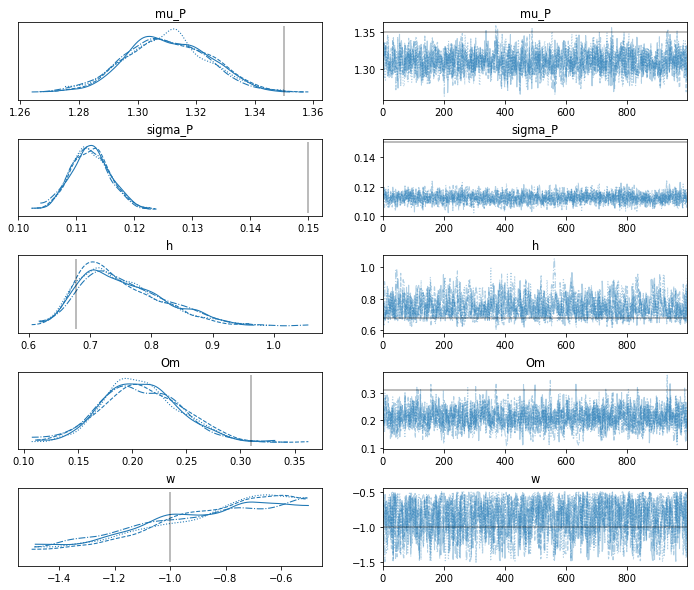

In [21]:
with model:
    axes = az.plot_trace(trace, compact=True, var_names=['mu_P', 'sigma_P', 'h', 'Om', 'w'],
                        lines=[('mu_P', {}, 1.35),
                        ('sigma_P', {}, 0.15),
                        ('h', {}, cp.H0/100),
                        ('Om', {}, cp.Om0),
                        ('w', {}, -1)])
    fig = axes.ravel()[0].figure.subplots_adjust(hspace=0.5)

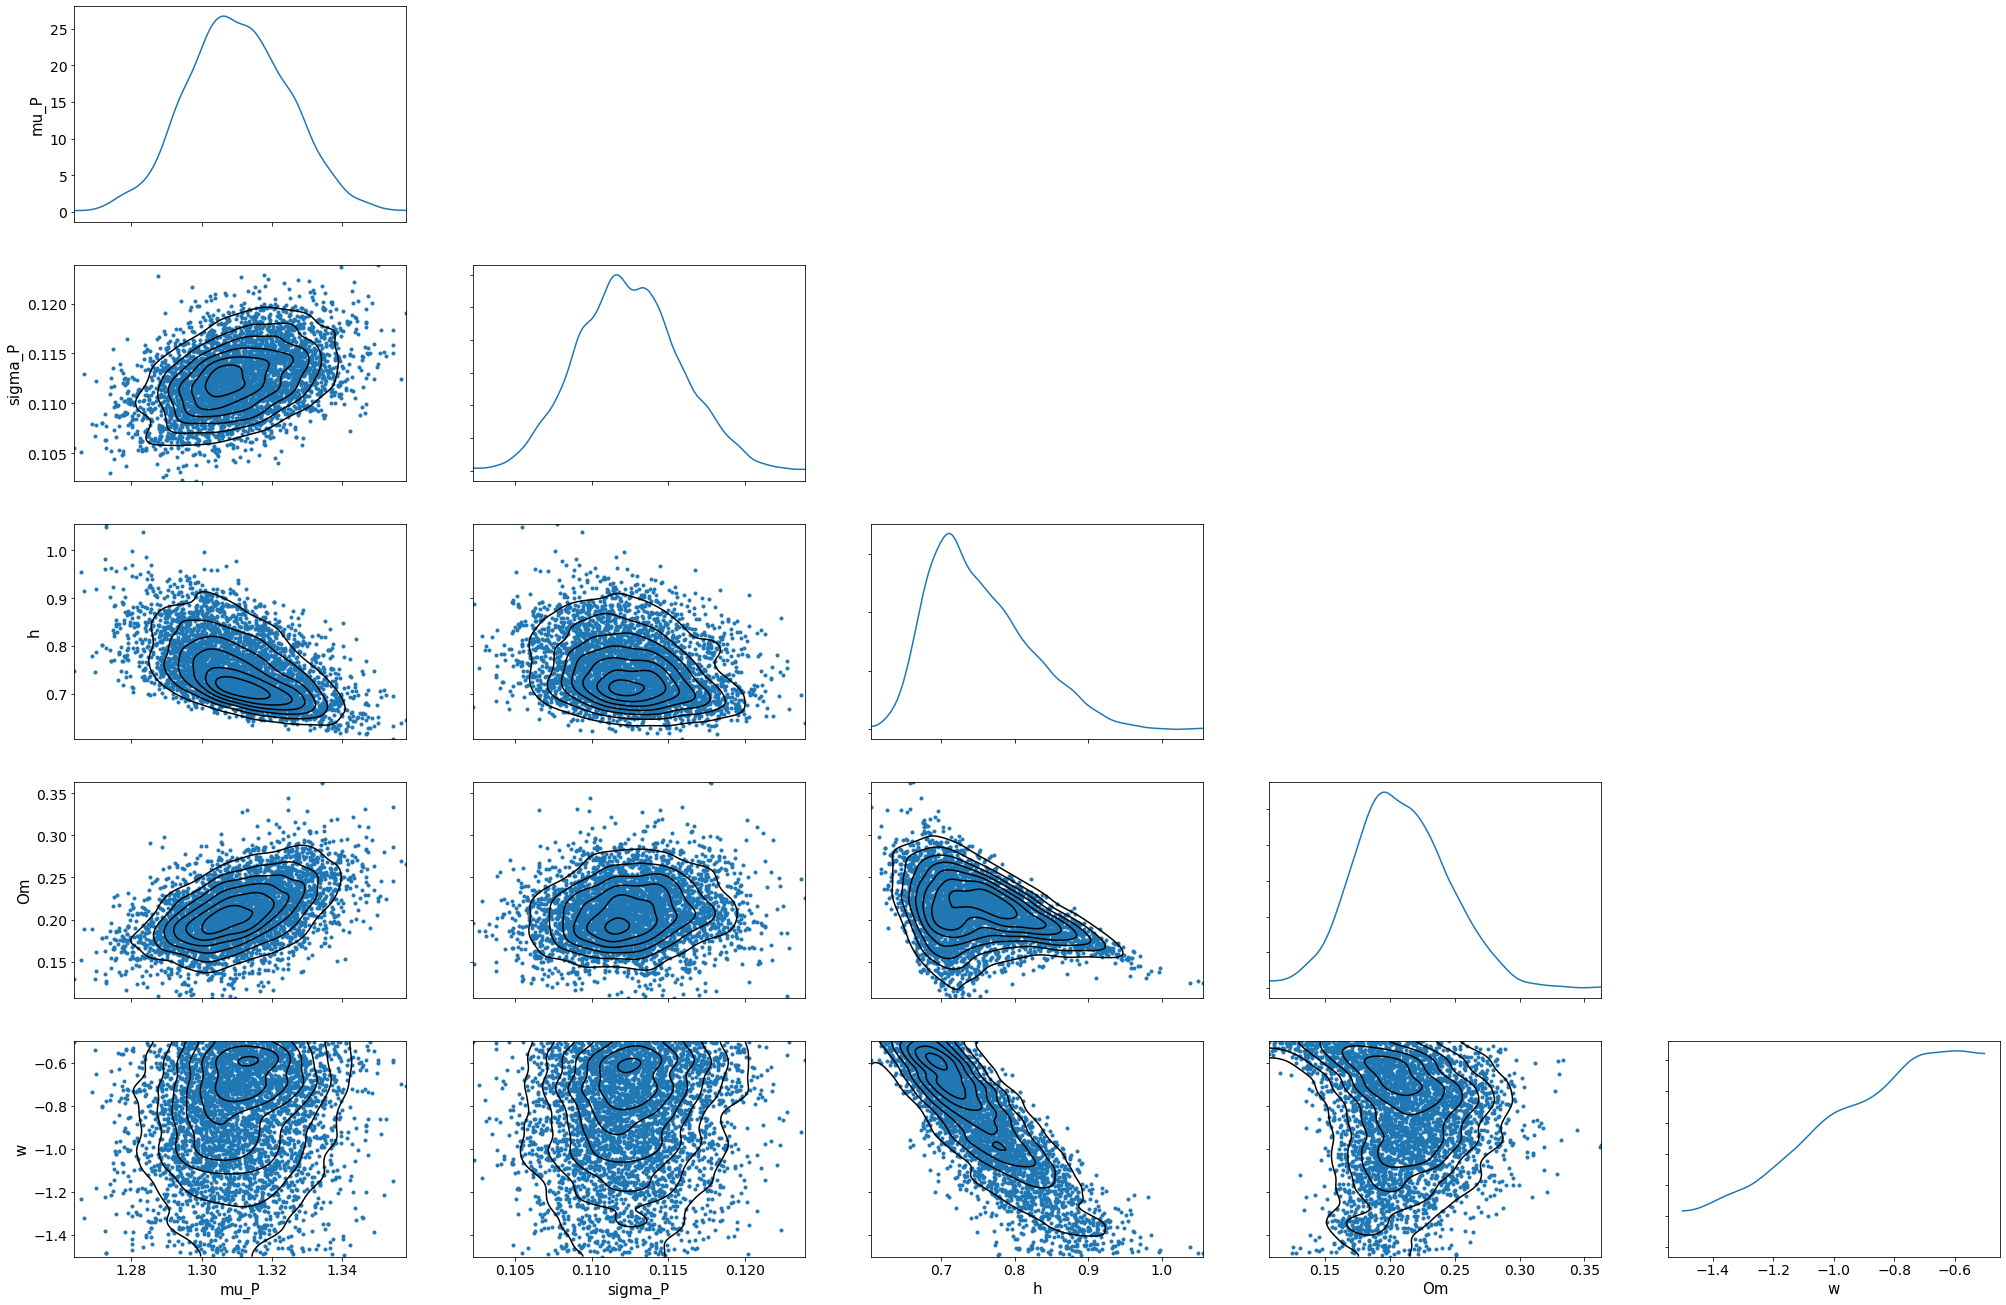

In [22]:
axes = az.plot_pair(trace, var_names=['mu_P', 'sigma_P', 'h', 'Om', 'w'], marginals=True, kind=['scatter', 'kde'], divergences=True)
fig = axes.ravel()[0].figure

In [23]:
with model:
    display(az.summary(trace, var_names=['mu_P', 'sigma_P', 'h', 'Om', 'w']))

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu_P,1.310,0.014,1.285,1.338,0.000,0.000,1437.0,1423.0,1.0
sigma_P,0.112,0.003,0.106,0.119,0.000,0.000,1962.0,1831.0,1.0
h,0.752,0.067,0.649,0.886,0.002,0.002,1060.0,1212.0,1.0
Om,0.208,0.036,0.148,0.283,0.001,0.001,1527.0,1362.0,1.0
w,-0.868,0.251,-1.329,-0.501,0.008,0.005,1081.0,1495.0,1.0
